<a href="https://colab.research.google.com/github/karankishinani/Emotion-detection-from-text-using-PyTorch-and-Federated-Learning/blob/master/Emotion_detection_from_text_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion detection from text using PyTorch and Federated Learning

For this project, we are going to implement an NLP task of creating a model to detect the emotion from text. We will develop this using the PyTorch library and the Federated Learning framework for decentralized training. 

We will create an emotion detection for the following 5 emotions:

| Emotion | Emoji   | Label   |
|------|------|------|
|Loving| ❤️| 0|
|Playful| ⚽️| 1|
|Happy| 😄| 2|
|Annoyed| 😞| 3|
|Foodie| 🍽| 4|


## The Model
We will build an LSTM model that takes as input word sequences that will take word ordering into account. We will use 50-dimensional [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained word embeddings to represent words. We will then feed those as an input into an LSTM that will predict the most appropiate emotion for the text. 



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# HELPER FUNCTIONS

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def read_csv(filename):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [0]:
X_train, Y_train = read_csv('train.csv')
X_test, Y_test = read_csv('test.csv')

In [0]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [0]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    """
    
    m = X.shape[0]  # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):  # loop over training examples
        
        # Convert the ith sentence in lower case and split into a list of words
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1
    
    return X_indices

In [11]:
X1 = np.array(["lol", "I love you", "this is very yummy"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['lol' 'I love you' 'this is very yummy']
X1_indices = [[225122.      0.      0.      0.      0.]
 [185457. 226278. 394475.      0.      0.]
 [358160. 192973. 377946. 394957.      0.]]


## Defining the Network using Pretrained Embedding Layer using GloVe Word Embeddings

In [0]:
class NN(nn.Module):
  def __init__(self, embedding, embedding_dim, hidden_dim, vocab_size, output_dim, batch_size):
      super(NN, self).__init__()

      self.batch_size = batch_size

      self.hidden_dim = hidden_dim

      self.word_embeddings = embedding

      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=2,
                          dropout = 0.5,
                          batch_first = True)

      # The linear layer that maps from hidden state space to output space
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, sentence):
      
      #sentence = sentence.type(torch.LongTensor)
      #print ('Shape of sentence is:', sentence.shape)

      sentence = sentence.to(device)

      embeds = self.word_embeddings(sentence)
      #print ('Embedding layer output shape', embeds.shape)

      # initializing the hidden state to 0
      #hidden=None
      
      h0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      c0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      
      lstm_out, h = self.lstm(embeds, (h0, c0))
      # get info from last timestep only
      lstm_out = lstm_out[:, -1, :]
      #print ('LSTM layer output shape', lstm_out.shape)
      #print ('LSTM layer output ', lstm_out)

      # Dropout
      lstm_out = F.dropout(lstm_out, 0.5)

      fc_out = self.fc(lstm_out)
      #print ('FC layer output shape', fc_out.shape)
      #print ('FC layer output ', fc_out)
      
      out = fc_out
      out = F.softmax(out, dim=1)
      #print ('Output layer output shape', out.shape)
      #print ('Output layer output ', out)
      return out
  

## Creating the Glove Embedding Layer

In [0]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True):
    num_embeddings = len(word_to_index) + 1                   
    embedding_dim = word_to_vec_map["cucumber"].shape[0]  #  dimensionality of GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (num_embeddings, embedding_dim)
    weights_matrix = np.zeros((num_embeddings, embedding_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        weights_matrix[index, :] = word_to_vec_map[word]

    embed = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).type(torch.FloatTensor), freeze=non_trainable)

    return embed, num_embeddings, embedding_dim


## Training the model

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, trainloader, criterion, optimizer, epochs=10):
    
    model.to(device)
    running_loss = 0
    
    train_losses, test_losses, accuracies = [], [], []
    for e in range(epochs):

        running_loss = 0
        
        model.train()
        
        for sentences, labels in trainloader:

            sentences, labels = sentences.to(device), labels.to(device)

            # 1) erase previous gradients (if they exist)
            optimizer.zero_grad()

            # 2) make a prediction
            pred = model.forward(sentences)

            # 3) calculate how much we missed
            loss = criterion(pred, labels)

            # 4) figure out which weights caused us to miss
            loss.backward()

            # 5) change those weights
            optimizer.step()

            # 6) log our progress
            running_loss += loss.item()
        
        
        else:

          model.eval()

          test_loss = 0
          accuracy = 0
          
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():
              for sentences, labels in test_loader:
                  sentences, labels = sentences.to(device), labels.to(device)
                  log_ps = model(sentences)
                  test_loss += criterion(log_ps, labels)
                  
                  ps = torch.exp(log_ps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  
          train_losses.append(running_loss/len(train_loader))
          test_losses.append(test_loss/len(test_loader))
          accuracies.append(accuracy / len(test_loader) * 100)

          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        
    # Plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_losses, c='b', label='Training loss')
    plt.plot(test_losses, c='r', label='Testing loss')
    plt.xticks(np.arange(0, epochs))
    plt.title('Losses')
    plt.legend(loc='upper right')
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(accuracies)
    plt.xticks(np.arange(0, epochs))
    plt.title('Accuracy')
    plt.show()
         



In [29]:
X_train_indices.shape

(132, 10)

In [27]:
Y_train_oh.shape

(132, 5)

In [28]:
Y_train.shape

(132,)

In [26]:
X_test_indices.shape

(56, 10)

In [17]:
X_train.shape

(132,)

Epoch: 1/50..  Training Loss: 1.608..  Test Loss: 1.596..  Test Accuracy: 0.318
Epoch: 2/50..  Training Loss: 1.583..  Test Loss: 1.569..  Test Accuracy: 0.276
Epoch: 3/50..  Training Loss: 1.582..  Test Loss: 1.562..  Test Accuracy: 0.240
Epoch: 4/50..  Training Loss: 1.558..  Test Loss: 1.545..  Test Accuracy: 0.344
Epoch: 5/50..  Training Loss: 1.532..  Test Loss: 1.533..  Test Accuracy: 0.370
Epoch: 6/50..  Training Loss: 1.496..  Test Loss: 1.490..  Test Accuracy: 0.411
Epoch: 7/50..  Training Loss: 1.449..  Test Loss: 1.471..  Test Accuracy: 0.411
Epoch: 8/50..  Training Loss: 1.386..  Test Loss: 1.457..  Test Accuracy: 0.432
Epoch: 9/50..  Training Loss: 1.346..  Test Loss: 1.434..  Test Accuracy: 0.521
Epoch: 10/50..  Training Loss: 1.410..  Test Loss: 1.509..  Test Accuracy: 0.396
Epoch: 11/50..  Training Loss: 1.431..  Test Loss: 1.477..  Test Accuracy: 0.385
Epoch: 12/50..  Training Loss: 1.361..  Test Loss: 1.446..  Test Accuracy: 0.453
Epoch: 13/50..  Training Loss: 1.320.

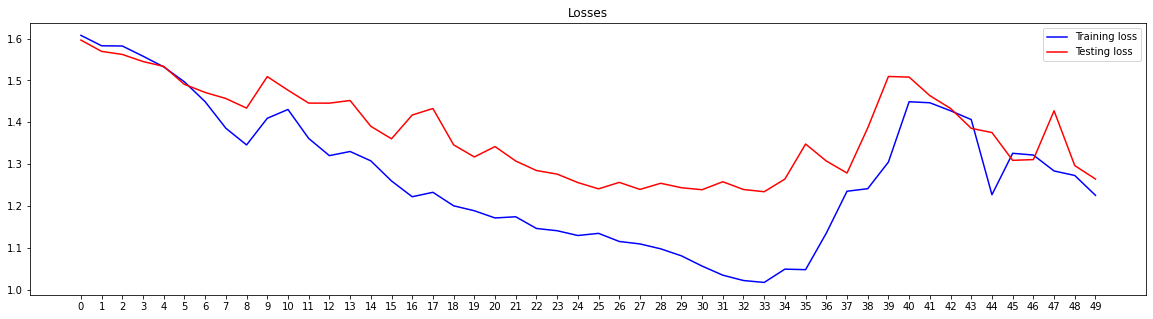

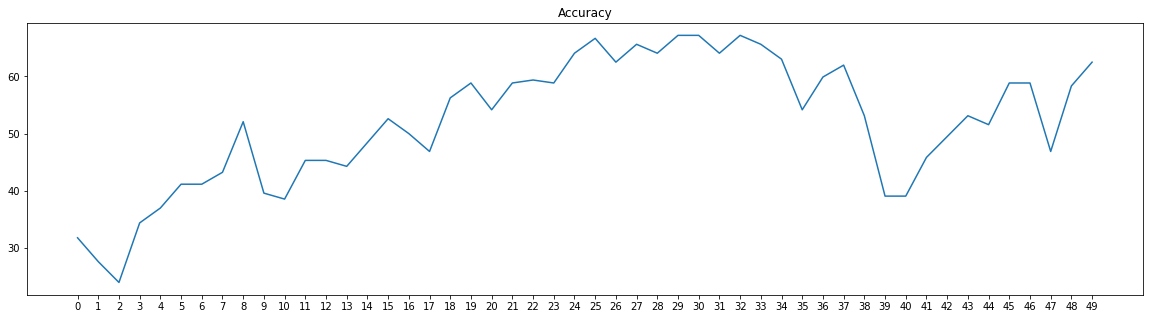

In [18]:
import torch.utils.data

maxLen = len(max(X_train, key=len).split())
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)

embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True)

hidden_dim=128
output_size=5
batch_size = 32

#print ('Embedding layer is ', embedding)
#print ('Embedding layer weights ', embedding.weight.shape)

model = NN(embedding, embedding_dim, hidden_dim, vocab_size, output_size, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
epochs = 50
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_indices).type(torch.LongTensor), torch.tensor(Y_train).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_indices).type(torch.LongTensor), torch.tensor(Y_test).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train(model, train_loader, criterion, optimizer, epochs)

## Testing the Model Accuracy

In [19]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for sentences, labels in test_loader:
        sentences, labels = sentences.to(device), labels.to(device)
        ps = model(sentences)
        test_loss += criterion(ps, labels).item()

        # Accuracy
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
model.train()
print("Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
running_loss = 0

Test Loss: 1.268..  Test Accuracy: 0.625


## Testing the model with any sentence

In [0]:
def predict(input_text, print_sentence=True):
  labels_dict = {
		0 : "❤️ Loving",
		1 : "⚽️ Playful",
		2 : "😄 Happy",
		3 : "😞 Annoyed",
		4 : "🍽 Foodie",
	}

  # Convert the input to the model
  x_test = np.array([input_text])
  X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
  sentences = torch.tensor(X_test_indices).type(torch.LongTensor)

  # Get the class label
  ps = model(sentences)
  top_p, top_class = ps.topk(1, dim=1)
  label = int(top_class[0][0])

  if print_sentence:
    print("\nInput Text: \t"+ input_text +'\nEmotion: \t'+  labels_dict[label])

  return label

In [21]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
print("------------------------------------")
predict("I hate you")
predict("I want a pizza")
predict("Lets see the game")
predict("I love you Lisa")
predict("This is the best day of my life")
predict("leave me alone")
print("\n------------------------------------")

------------------------------------

Input Text: 	I hate you
Emotion: 	❤️ Loving

Input Text: 	I want a pizza
Emotion: 	🍽 Foodie

Input Text: 	Lets see the game
Emotion: 	⚽️ Playful

Input Text: 	I love you Lisa
Emotion: 	❤️ Loving

Input Text: 	This is the best day of my life
Emotion: 	😄 Happy

Input Text: 	leave me alone
Emotion: 	😄 Happy

------------------------------------


## Federated Learning



In [22]:
!pip install syft
import syft as sy  # <-- import the Pysyft library
hook = sy.TorchHook(torch)  # <-- hook PyTorch to add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- define remote worker alice

In [0]:
size = len(X_train_indices)

bobs_data = sy.BaseDataset(torch.tensor(X_train_indices[:size//2]).type(torch.LongTensor), torch.tensor(Y_train[:size//2]).type(torch.LongTensor)).send(bob)
alices_data = sy.BaseDataset(torch.tensor(X_train_indices[size//2+1:]).type(torch.LongTensor), torch.tensor(Y_train[size//2+1:]).type(torch.LongTensor)).send(alice)
federated_train_dataset = sy.FederatedDataset([bobs_data, alices_data])
federated_train_loader = sy.FederatedDataLoader(federated_train_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_indices).type(torch.LongTensor), torch.tensor(Y_test).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [0]:
def federated_train(model, trainloader, criterion, optimizer, epochs=10):
    
    running_loss = 0
    
    train_losses, test_losses, accuracies = [], [], []
    for e in range(epochs):

        running_loss = 0
        
        model.train()
        
        for batch_idx, (sentences, labels) in enumerate(federated_train_loader):

            model.send(sentences.location)

            # 1) erase previous gradients (if they exist)
            optimizer.zero_grad()

            # 2) make a prediction
            pred = model(sentences)

            # 3) calculate how much we missed
            loss = criterion(pred, labels)

            # 4) figure out which weights caused us to miss
            loss.backward()

            # 5) change those weights
            optimizer.step()

            # 6) get the model and loss back
            model.get()
            loss = loss.get()

            # 7) log our progress
            running_loss += loss.item()
        
        
        else:

          model.eval()

          test_loss = 0
          accuracy = 0
          
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():
              for sentences, labels in test_loader:

                  log_ps = model(sentences)
                  test_loss += criterion(log_ps, labels)
                  
                  ps = torch.exp(log_ps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  
          train_losses.append(running_loss/len(train_loader))
          test_losses.append(test_loss/len(test_loader))
          accuracies.append(accuracy / len(test_loader) * 100)

          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        
    # Plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_losses, c='b', label='Training loss')
    plt.plot(test_losses, c='r', label='Testing loss')
    plt.xticks(np.arange(0, epochs))
    plt.title('Losses')
    plt.legend(loc='upper right')
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(accuracies)
    plt.xticks(np.arange(0, epochs))
    plt.title('Accuracy')
    plt.show()

In [25]:
device = torch.device("cpu")
embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=False)
federated_model = NN(embedding, embedding_dim, hidden_dim, vocab_size, output_size, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(federated_model.parameters(), lr=0.002)
epochs = 50

federated_train(federated_model, train_loader, criterion, optimizer, epochs)

RuntimeError: ignored

In [0]:
data = pd.read_csv('iseardataset.csv')

different dataset with 7000 entries and classified into 7 emotions,not using any pre-trained word-embedings like glove,used LSTM

In [0]:

data = data[['text','label']]

In [32]:
data.label.value_counts()

joy        1092
sadness    1082
anger      1079
fear       1076
shame      1071
disgust    1066
guilt      1050
Name: label, dtype: int64

In [0]:
data['labels'] = 0

In [0]:
data.loc[data['label'] =='joy' , 'labels'] = 0
data.loc[data['label'] =='sadness' , 'labels'] = 1
data.loc[data['label'] =='anger' , 'labels'] = 2
data.loc[data['label'] =='fear' , 'labels'] = 3
data.loc[data['label'] =='shame' , 'labels'] = 4
data.loc[data['label'] =='disgust' , 'labels'] = 5
data.loc[data['label'] =='guilt' , 'labels'] = 6


In [35]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(data['labels'], num_classes=7)

Using TensorFlow backend.


In [36]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
maxLen = len(max(data['text'], key=len).split())

In [38]:
print(maxLen)

168


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [41]:
n_most_common_words = 25000
max_len = maxLen
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)
sequences = tokenizer.texts_to_sequences(data['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 11242 unique tokens.


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [43]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [44]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((5637, 168), (5637, 7), (1879, 168), (1879, 7))


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [47]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

((5637, 168), (5637, 7), (1879, 168), (1879, 7))
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 168, 128)          3200000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 3,249,863
Trainable params: 3,249,863
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4509 samples, validate on 1128 samples
Epoch 1/10





4509/4509 [==============================] - 9s 2ms/step - loss: 1.9444 - acc: 0.1608 - val_loss: 1.9403 - val_acc: 0.2021
Epoch 2/10
4509/4509 [==============

In [48]:
history=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,verbose = 2)

Train on 4509 samples, validate on 1128 samples
Epoch 1/10
 - 7s - loss: 1.0610 - acc: 0.6766 - val_loss: 1.4319 - val_acc: 0.4681
Epoch 2/10
 - 7s - loss: 0.9514 - acc: 0.7166 - val_loss: 1.4203 - val_acc: 0.4637
Epoch 3/10
 - 7s - loss: 0.8422 - acc: 0.7503 - val_loss: 1.4139 - val_acc: 0.4805
Epoch 4/10
 - 7s - loss: 0.7428 - acc: 0.7893 - val_loss: 1.4202 - val_acc: 0.4902
Epoch 5/10
 - 7s - loss: 0.6619 - acc: 0.8053 - val_loss: 1.4384 - val_acc: 0.4894
Epoch 6/10
 - 7s - loss: 0.5911 - acc: 0.8197 - val_loss: 1.4568 - val_acc: 0.4982
Epoch 7/10
 - 7s - loss: 0.5274 - acc: 0.8556 - val_loss: 1.4871 - val_acc: 0.4902
Epoch 8/10
 - 7s - loss: 0.4721 - acc: 0.8634 - val_loss: 1.4991 - val_acc: 0.5142
Epoch 9/10
 - 7s - loss: 0.4375 - acc: 0.8720 - val_loss: 1.5432 - val_acc: 0.5009
Epoch 10/10
 - 7s - loss: 0.3847 - acc: 0.8909 - val_loss: 1.5680 - val_acc: 0.4911


In [0]:
data = pd.read_csv('data.csv')

used a dataset with 40k entries and are classified into 5 emotions.Glove embeddings are used for text pre-processing.
Choice of Neural Network Model:
RNNs, especially LSTMs, are preferred for many NLP tasks as it "learns" the significance of order of sequential data(text)
CNNs extract features from data to identify them. Previous approaches either use one method.
Hybrid approach by using both in the same model.


===>We take elements from each of the above models and extend the idea of creating multi-channel networks where we allow the model to attempt to self-learn which channels allow it to get better predictions for certain classes of data.
We call our prototype neural network **BalanceNet.**

In [58]:
data.shape

(47287, 2)

In [0]:
data.columns = ['First','Second']

In [64]:
type(data['First'])

pandas.core.series.Series

In [61]:
data['Second'].value_counts()


1    16297
2    15938
0     9643
3     4301
4     1108
Name: Second, dtype: int64

In [65]:
MAX_NB_WORDS = 40000 # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 30 # max length of text (words) including padding
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 200 # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "/content/glove.6B.50d.txt"
print("[i] Loaded Parameters:\n",
      MAX_NB_WORDS,MAX_SEQUENCE_LENGTH+5,
      VALIDATION_SPLIT,EMBEDDING_DIM,"\n",
      GLOVE_DIR)

[i] Loaded Parameters:
 40000 35 0.2 200 
 /content/glove.6B.50d.txt


In [0]:
import numpy as np
import pandas as pd
import re, sys, os, csv, keras, pickle

In [70]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Concatenate
from keras.layers import Conv1D, MaxPooling1D,Add, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
print("[+] Using Keras version",keras.__version__)

[+] Using Keras version 2.2.5
ERROR! Session/line number was not unique in database. History logging moved to new session 61


In [71]:
texts, labels = [], []
print("[i] Reading from csv file...", end="")
with open('data.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        texts.append(row[0])
        labels.append(row[1])
print("Done!")

[i] Reading from csv file...Done!


In [72]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("[i] Saved word tokenizer to file: tokenizer.pickle")

[i] Saved word tokenizer to file: tokenizer.pickle


In [0]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [74]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('[i] Found %s unique tokens.' % len(word_index))
data_int = pad_sequences(sequences, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data = pad_sequences(data_int, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

[i] Found 34359 unique tokens.


In [75]:
labels = to_categorical(np.asarray(labels)) # convert to one-hot encoding vectors
print('[+] Shape of data tensor:', data.shape)
print('[+] Shape of label tensor:', labels.shape)

[+] Shape of data tensor: (47288, 30)
[+] Shape of label tensor: (47288, 5)


In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [77]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('[i] Number of entries in each category:')
print("[+] Training:\n",y_train.sum(axis=0))
print("[+] Validation:\n",y_val.sum(axis=0))

[i] Number of entries in each category:
[+] Training:
 [ 7799. 13029. 12693.  3423.   887.]
[+] Validation:
 [1844. 3268. 3245.  878.  222.]


In [0]:
EMBEDDING_DIM = 50

In [80]:
embeddings_index = {}
f = open(GLOVE_DIR)
print("[i] Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n[+] Proceeding with Embedding Matrix...", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print("[i] Completed!")

[i] Loading GloVe from: /content/glove.6B.50d.txt ...Done.
[+] Proceeding with Embedding Matrix...[i] Completed!


In [0]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [0]:
def initial_boost(epoch):
    if epoch==0: return float(8.0)
    elif epoch==1: return float(4.0)
    elif epoch==2: return float(2.0)
    elif epoch==3: return float(1.5)
    else: return float(1.0)

In [0]:
def step_cyclic(epoch):
    try:
        l_r, decay = 1.0, 0.0001
        if epoch%33==0:multiplier = 10
        else:multiplier = 1
        rate = float(multiplier * l_r * 1/(1 + decay * epoch))
        #print("Epoch",epoch+1,"- learning_rate",rate)
        return rate
    except Exception as e:
        print("Error in lr_schedule:",str(e))
        return float(1.0)

In [84]:
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [0]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

In [0]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [0]:
from keras import regularizers

In [0]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

In [0]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

In [92]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [0]:
from keras import optimizers

In [0]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [97]:
from keras import callbacks

ERROR! Session/line number was not unique in database. History logging moved to new session 62


In [0]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [99]:
model.summary()
model.save('BalanceNet.h5')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 30, 50)       1718000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 30, 50)       1718000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       2736        embedding_4[0][0]                
____________________________________________________________________________________________

In [0]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=35, batch_size=128,
          callbacks=[tensorboard, model_checkpoints])

pandas.DataFrame(model_log.history).to_csv("history-balance.csv")


In [107]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=25, batch_size=128,
          callbacks=[tensorboard, model_checkpoints])

pandas.DataFrame(model_log.history).to_csv("history-balance.csv")


Training Progress:
Train on 37831 samples, validate on 9457 samples
Epoch 1/25
37831/37831 [==============================] - 86s 2ms/step - loss: 0.9549 - acc: 0.6025 - val_loss: 0.9594 - val_acc: 0.6000
Epoch 2/25
37831/37831 [==============================] - 82s 2ms/step - loss: 0.9546 - acc: 0.6042 - val_loss: 0.9585 - val_acc: 0.6012
Epoch 3/25
37831/37831 [==============================] - 83s 2ms/step - loss: 0.9536 - acc: 0.6051 - val_loss: 0.9583 - val_acc: 0.6007
Epoch 4/25
37831/37831 [==============================] - 82s 2ms/step - loss: 0.9538 - acc: 0.6029 - val_loss: 0.9573 - val_acc: 0.6024
Epoch 5/25
37831/37831 [==============================] - 83s 2ms/step - loss: 0.9542 - acc: 0.6027 - val_loss: 0.9581 - val_acc: 0.6005
Epoch 6/25
37831/37831 [==============================] - 82s 2ms/step - loss: 0.9521 - acc: 0.6020 - val_loss: 0.9569 - val_acc: 0.6034
Epoch 7/25
37831/37831 [==============================] - 81s 2ms/step - loss: 0.9512 - acc: 0.6046 - val_loss

NameError: ignored

In [0]:
pd.DataFrame(model_log.history).to_csv("history-balance.csv")

In [0]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["neutral", "happy", "sad", "hate","anger"]

In [110]:
!ls

BalanceNet.h5	     checkpoint-0.969.h5  checkpoint-1.041.h5
checkpoint-0.952.h5  checkpoint-0.971.h5  checkpoint-1.056.h5
checkpoint-0.953.h5  checkpoint-0.974.h5  checkpoint-1.073.h5
checkpoint-0.954.h5  checkpoint-0.975.h5  checkpoint-1.103.h5
checkpoint-0.956.h5  checkpoint-0.978.h5  checkpoint-1.190.h5
checkpoint-0.957.h5  checkpoint-0.981.h5  data.csv
checkpoint-0.958.h5  checkpoint-0.982.h5  glove.6B.50d.txt
checkpoint-0.959.h5  checkpoint-0.988.h5  history-balance.csv
checkpoint-0.960.h5  checkpoint-0.992.h5  iseardataset.csv
checkpoint-0.962.h5  checkpoint-0.997.h5  logs
checkpoint-0.964.h5  checkpoint-1.002.h5  sample_data
checkpoint-0.965.h5  checkpoint-1.007.h5  test.csv
checkpoint-0.966.h5  checkpoint-1.018.h5  tokenizer.pickle
checkpoint-0.967.h5  checkpoint-1.026.h5  train.csv


In [0]:

#model_test = load_model('checkpoint-0.866.h5')
#model_test = load_model('best_weights.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
#y_pred = model_test.predict(x_val)
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [112]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     neutral       0.42      0.38      0.40      1844
       happy       0.61      0.69      0.65      3268
         sad       0.62      0.63      0.62      3245
        hate       0.88      0.62      0.73       878
       anger       0.95      0.73      0.83       222

    accuracy                           0.60      9457
   macro avg       0.69      0.61      0.65      9457
weighted avg       0.61      0.60      0.60      9457



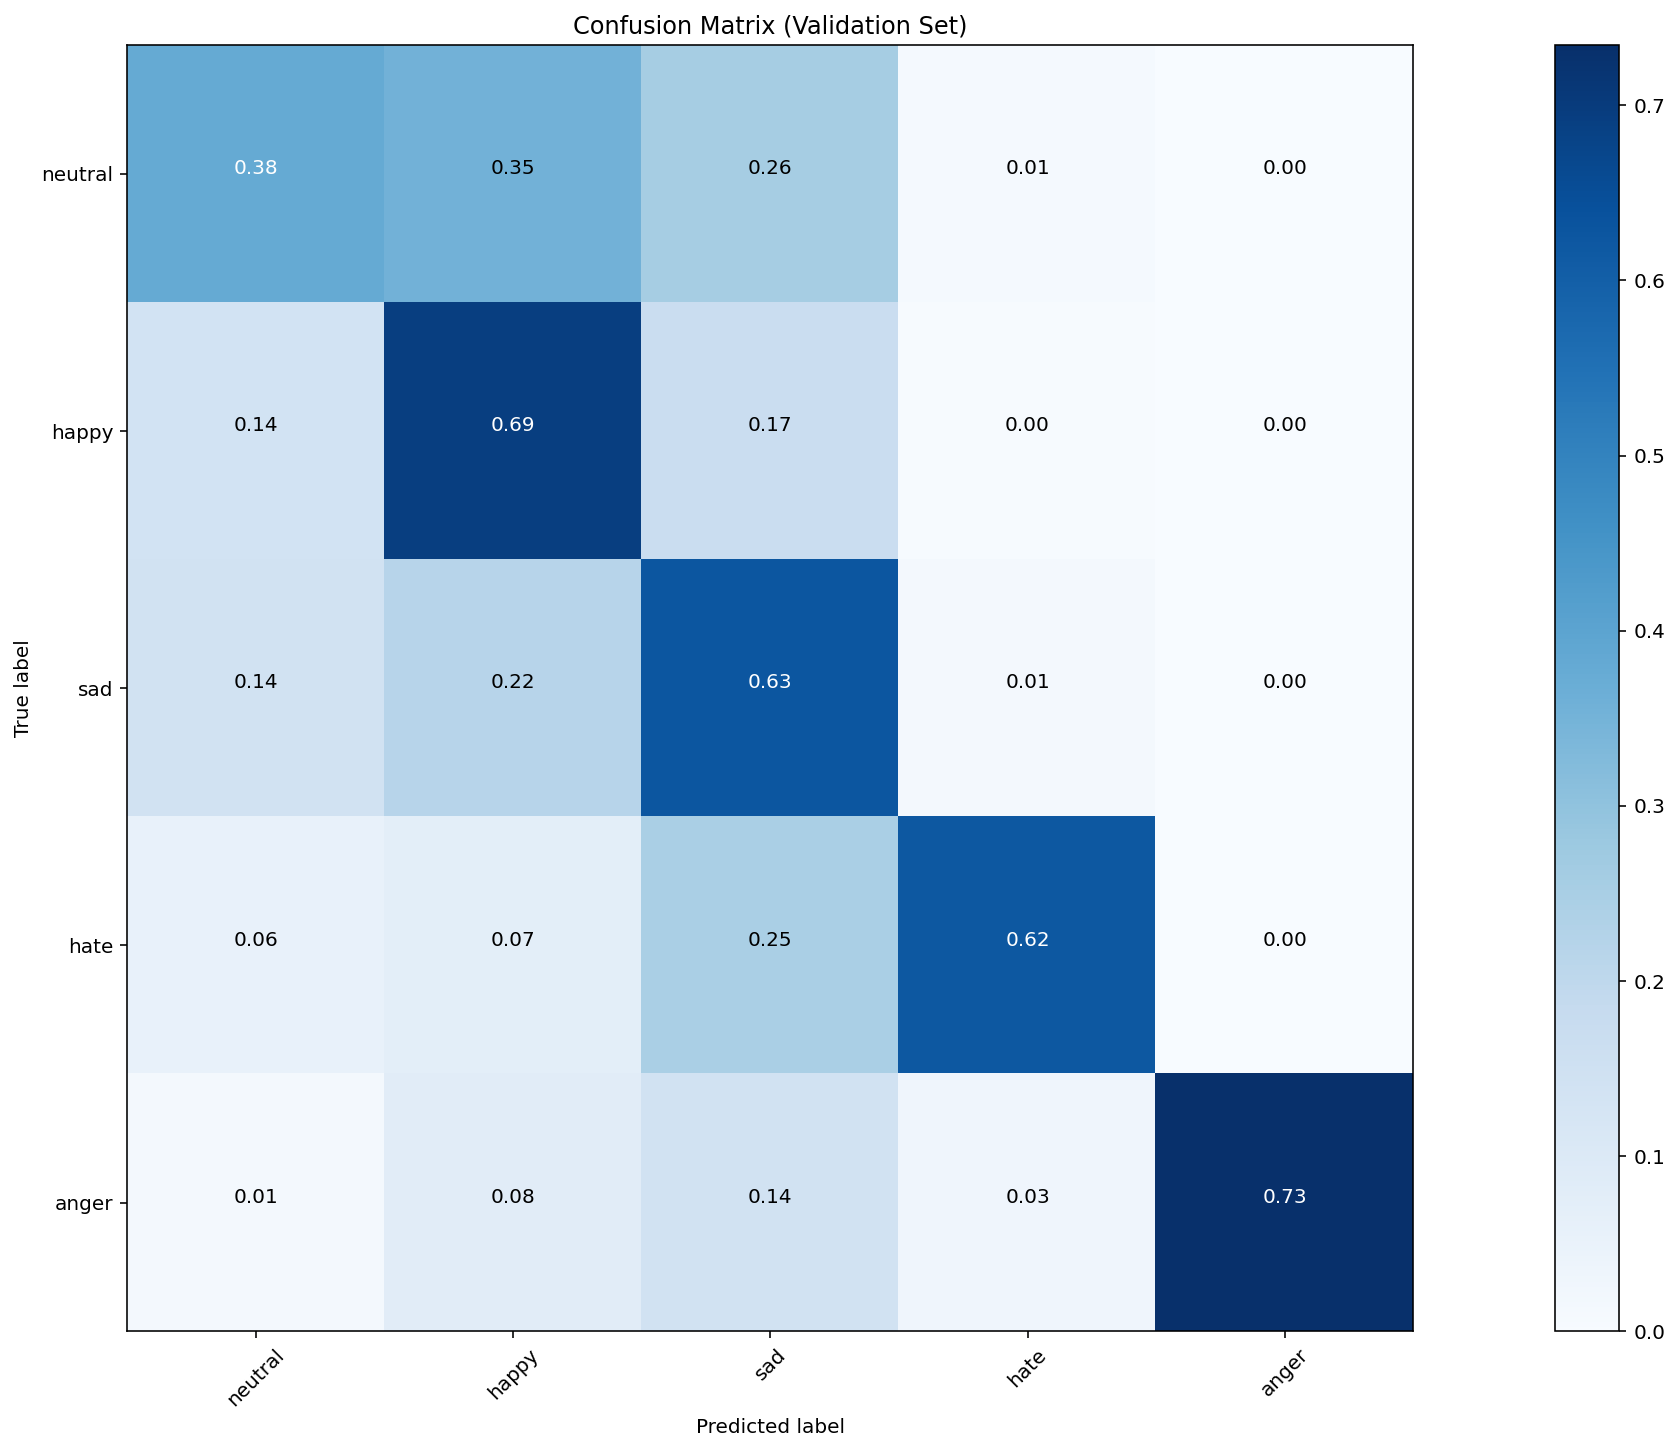

In [113]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [0]:
text = ["I salute you for the bravery and sacrifice! A true hero indeed.",
        "I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!?",
        "PAP are taking the piss again!",
        "Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism",
        "Somebody needs to water Tharman's head, hair needs to be grown there",
        "what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen?",
        "What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la"
       ]

In [115]:
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

I salute you for the bravery and sacrifice! A true hero indeed. 
Prediction: happy 

I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!? 
Prediction: sad 

PAP are taking the piss again! 
Prediction: neutral 

Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism 
Prediction: sad 

Somebody needs to water Tharman's head, hair needs to be grown there 
Prediction: neutral 

what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen? 
Prediction: sad 

What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la 
Prediction: happy 



In [116]:
np.array(sequences_test[0])

array([   1, 6097,    5,   12,    3,    6, 4841,    4,  515, 1476, 1238])

In [0]:
text = ["never talk to me again",
        "do not get angry or frustrated or desperate or enraged or depressed or any such thing you are all educated",
        "i hate worthless insights",
        "it is the worst day of my life",
        "i love you mom",
        "stop saying bullshit",
        "congratulations on your acceptance",
        "your stupidity has no limt",
        "sounds like a fun plan",
        "i will celebrate soon",
        "the game just finished",
        "you are so mean"]

In [126]:
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

never talk to me again 
Prediction: neutral 

do not get angry or frustrated or desperate or enraged or depressed or any such thing you are all educated 
Prediction: anger 

i hate worthless insights 
Prediction: hate 

it is the worst day of my life 
Prediction: sad 

i love you mom 
Prediction: happy 

stop saying bullshit 
Prediction: sad 

congratulations on your acceptance 
Prediction: happy 

your stupidity has no limt 
Prediction: sad 

sounds like a fun plan 
Prediction: happy 

i will celebrate soon 
Prediction: happy 

the game just finished 
Prediction: happy 

you are so mean 
Prediction: neutral 

